
# PPE COMPLIANCE DETECTION using YOLO

### By : Gagan Gireesh Krishna and S Sreyas

----

# 1. Dataset Initialization

In this section, we will initialize the dataset by mounting Google Drive and extracting the zipped dataset into the Colab environment.

In [2]:
# Install the ultralytics library for YOLOv8 and opencv-python for image processing
pip install ultralytics opencv-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 32.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 123.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 92.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 65.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 16.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 108.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstallin

In [1]:
# Import necessary libraries
from google.colab import drive
import zipfile

# Mount Google Drive to access files
drive.mount('/content/drive')

# Unzip the dataset from Google Drive to the Colab environment
zip_ref = zipfile.ZipFile("/content/drive/My Drive/s4-Internship/PPE-DETECTION-dataset.zip", 'r')
zip_ref.extractall("/content/PPe-Det")
zip_ref.close()

Mounted at /content/drive


In [3]:
# Install the imgaug library for image augmentation
!pip install imgaug

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 948.0/948.0 kB 15.6 MB/s eta 0:00:00


In [5]:
# Downgrade numpy to a version compatible with the other installed libraries
!pip install numpy==1.25

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.6/17.6 MB 86.5 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opencv-contrib-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.25.0 which is incompatible.
opencv-python-headless 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.25.0 which is incompatible.
xarray 2025.7.1 requires numpy>=1.26, but you have numpy 1.25.0 which is incompatible.
blosc2 3.6.1 requires numpy>=1.26, but you have numpy 1.25.0 which is incompatible.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.25.0 which is incompatible.
treescope 0.1.9 requires numpy>=1.25.2, but you have numpy 1.25.0 which

# 2. Data Preprocessing and Augmentation

This section covers the preprocessing of the images, including resizing and normalization. We will also apply data augmentation techniques to the training set to increase the diversity of the data and improve the model's robustness.

In [1]:
# Import necessary libraries for image processing and augmentation
import os
import cv2
import numpy as np
import imgaug.augmenters as iaa
import shutil

# --- Configuration ---
# Set the input and output directories for the dataset
input_dataset_dir = '/content/PPe-Det'
output_dataset_dir = '/content/PPe-Det-Final'

# Set the desired image size for resizing
IMG_SIZE = (640, 640)

# --- Augmentation Pipeline ---
# Define a sequence of image augmentations to be applied to the training data
augmentation_pipeline = iaa.Sequential([
    # Randomly adjust the brightness of the image
    iaa.Multiply((0.8, 1.2), per_channel=0.2),
    # Apply affine transformations (scaling, translation, rotation, and shearing)
    iaa.Affine(
        scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
        translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)},
        rotate=(-15, 15),
        shear=(-8, 8)
    )
], random_order=True)  # Apply augmentations in a random order

# --- Helper Function ---
def process_and_save_split(split_name, apply_augmentation=False):
    """
    This function processes images from a given split (train, valid, or test),
    applies transformations and augmentations, and saves them to the output directory.
    """
    print(f"🔄 Processing '{split_name}' set...")

    # Define input and output directories for images and labels
    input_split_images_dir = os.path.join(input_dataset_dir, split_name, 'images')
    input_split_labels_dir = os.path.join(input_dataset_dir, split_name, 'labels')

    output_split_images_dir = os.path.join(output_dataset_dir, split_name, 'images')
    output_split_labels_dir = os.path.join(output_dataset_dir, split_name, 'labels')

    # Create output directories if they don't exist
    os.makedirs(output_split_images_dir, exist_ok=True)
    os.makedirs(output_split_labels_dir, exist_ok=True)

    # Get a list of all image files in the input directory
    image_files = [f for f in os.listdir(input_split_images_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

    # Process each image in the split
    for filename in image_files:
        img_path = os.path.join(input_split_images_dir, filename)
        label_filename = os.path.splitext(filename)[0] + '.txt'
        label_path = os.path.join(input_split_labels_dir, label_filename)

        # Read the image using OpenCV
        image = cv2.imread(img_path)
        if image is None:
            print(f"⚠️ Warning: Could not read image {img_path}. Skipping.")
            continue

        # Apply augmentation if specified
        if apply_augmentation:
            image = augmentation_pipeline(images=[image])[0]

        # --- Standard Preprocessing (Resize & Normalize) ---
        # Resize the image to the specified size
        image = cv2.resize(image, IMG_SIZE)
        # Normalize the image pixel values to be between 0 and 1
        image = image.astype(np.float32) / 255.0

        # --- Saving the processed files ---
        # Define the output path for the processed image
        output_image_path = os.path.join(output_split_images_dir, filename)
        # Save the processed image
        cv2.imwrite(output_image_path, (image * 255).astype(np.uint8))

        # Copy the corresponding label file to the output directory
        if os.path.exists(label_path):
            shutil.copy(label_path, os.path.join(output_split_labels_dir, label_filename))
        else:
            print(f"⚠️ Warning: Label for {filename} not found at {label_path}.")

    print(f"✅ Finished processing '{split_name}' set. Images saved to {output_split_images_dir}")


# --- Main Script ---
if __name__ == '__main__':
    # Process the training set with augmentation
    process_and_save_split('train', apply_augmentation=True)
    # Process the validation set without augmentation
    process_and_save_split('valid', apply_augmentation=False)
    # Process the test set without augmentation
    process_and_save_split('test', apply_augmentation=False)

    print("\n Dataset have been preprocessed successfully!")

/usr/local/lib/python3.11/dist-packages/imgaug/augmentables/kps.py:5: UserWarning: A NumPy version >=1.25.2 and <2.6.0 is required for this version of SciPy (detected version 1.25.0)
  import scipy.spatial.distance


🔄 Processing 'train' set...
✅ Finished processing 'train' set. Images saved to /content/PPe-Det-Final/train/images
🔄 Processing 'valid' set...
✅ Finished processing 'valid' set. Images saved to /content/PPe-Det-Final/valid/images
🔄 Processing 'test' set...
✅ Finished processing 'test' set. Images saved to /content/PPe-Det-Final/test/images

 Dataset have been preprocessed successfully!


# 3. Model Training

Here, we will train the YOLOv8 model on our preprocessed dataset. We will specify the number of epochs and other hyperparameters to guide the training process.

In [2]:
# Import the YOLO model from the ultralytics library and the os library
from ultralytics import YOLO
import os

# --- Train the Model ---
print("Training model...")

# Load the YOLOv8n model, which is a small and fast version of YOLOv8
model = YOLO('yolov8n.pt')

# Train the model on the preprocessed dataset
results = model.train(
    data='/content/PPe-Det/data.yaml',  # Path to the dataset configuration file
    epochs=100,                         # Number of training epochs
    imgsz=640,                          # Image size for training
    project='ppe_detection_project',    # Project name for saving results
    name='run3',                        # Run name for this specific training session
    weight_decay=0.0006                 # Weight decay for regularization
)

print(" Training complete.")

# --- Validate the Model ---
print("\n Starting model validation...")

# Get the directory where the training results are saved
run_dir = results.save_dir
# Get the path to the best performing model weights
best_weights_path = os.path.join(run_dir, 'weights/best.pt')
# Load the best model
model = YOLO(best_weights_path)

# Validate the model on the validation set
metrics = model.val()

print(" Validation complete.")
# Print the validation metrics (mAP50-95 and mAP50)
print(f"Validation Metrics: mAP50-95 = {metrics.box.map}, mAP50 = {metrics.box.map50}")


# --- Test the Model ---
print("\n Starting model testing...")

# Test the model on the test set
test_metrics = model.val(split='test')

print(" Testing complete.")
# Print the test metrics (mAP50-95 and mAP50)
print(f"Test Metrics: mAP50-95 = {test_metrics.box.map}, mAP50 = {test_metrics.box.map50}")

print("\n (Train, Validate, Test) are finished!")

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Training model...


100%|██████████| 6.25M/6.25M [00:00<00:00, 107MB/s]


Ultralytics 8.3.170 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/PPe-Det/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=run3, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0, pretrained=T

100%|██████████| 755k/755k [00:00<00:00, 20.6MB/s]

Overriding model.yaml nc=80 with nc=7

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

Model summary: 129 layers, 3,012,213 parameters, 3,012,197 gradients, 8.2 GFLOPs

Transferred 319/355 items from pretrained weights
Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...


100%|██████████| 5.35M/5.35M [00:00<00:00, 109MB/s]


AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1286.4±469.7 MB/s, size: 64.2 KB)


train: Scanning /content/PPe-Det/train/labels... 1059 images, 5 backgrounds, 0 corrupt: 100%|██████████| 1059/1059 [00:00<00:00, 2090.77it/s]


train: New cache created: /content/PPe-Det/train/labels.cache
WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 9, len(boxes) = 6566. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 433.9±78.5 MB/s, size: 57.9 KB)


val: Scanning /content/PPe-Det/valid/labels... 302 images, 4 backgrounds, 0 corrupt: 100%|██████████| 302/302 [00:00<00:00, 779.79it/s]

val: New cache created: /content/PPe-Det/valid/labels.cache


Plotting labels to ppe_detection_project/run3/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000909, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0006), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to ppe_detection_project/run3
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      2.53G      1.426      2.618      1.509         65        640: 100%|██████████| 67/67 [00:23<00:00,  2.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.45it/s]

                   all        302       1808      0.948      0.151      0.448      0.248



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      2.82G      1.375      1.551       1.45         33        640: 100%|██████████| 67/67 [00:18<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.90it/s]


                   all        302       1808      0.647      0.531      0.526      0.279

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      3.01G      1.378      1.449      1.459         21        640: 100%|██████████| 67/67 [00:19<00:00,  3.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.92it/s]


                   all        302       1808      0.614       0.63      0.536      0.293

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      3.03G      1.397      1.424      1.439         28        640: 100%|██████████| 67/67 [00:17<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.86it/s]


                   all        302       1808        0.7      0.502      0.533       0.28

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      3.04G      1.353       1.34      1.425         34        640: 100%|██████████| 67/67 [00:19<00:00,  3.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.03it/s]

                   all        302       1808      0.793      0.558      0.654      0.363



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      3.06G      1.348      1.281      1.421         38        640: 100%|██████████| 67/67 [00:17<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.93it/s]


                   all        302       1808      0.725      0.633      0.672      0.362

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      3.08G      1.319      1.245       1.39         39        640: 100%|██████████| 67/67 [00:19<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.08it/s]

                   all        302       1808      0.672      0.585      0.608      0.344



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100       3.1G      1.315      1.198      1.391         34        640: 100%|██████████| 67/67 [00:17<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.93it/s]


                   all        302       1808      0.743      0.665      0.672      0.369

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100       3.1G      1.296      1.184      1.382         13        640: 100%|██████████| 67/67 [00:19<00:00,  3.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.26it/s]

                   all        302       1808      0.806      0.629      0.698      0.416



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      3.13G      1.303      1.156      1.391         17        640: 100%|██████████| 67/67 [00:17<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.11it/s]


                   all        302       1808      0.749      0.646      0.722      0.418

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      3.14G      1.296      1.137      1.368         25        640: 100%|██████████| 67/67 [00:19<00:00,  3.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.99it/s]

                   all        302       1808      0.811      0.644      0.738      0.397



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      3.16G      1.282      1.105      1.371         40        640: 100%|██████████| 67/67 [00:17<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.35it/s]

                   all        302       1808      0.671      0.715      0.723      0.424



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      3.17G      1.282      1.119      1.376         35        640: 100%|██████████| 67/67 [00:19<00:00,  3.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.93it/s]


                   all        302       1808      0.817      0.598      0.721      0.408

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100       3.2G      1.257      1.056      1.357         23        640: 100%|██████████| 67/67 [00:17<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.17it/s]

                   all        302       1808      0.764      0.677      0.757      0.431



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      3.21G      1.228      1.022      1.328         28        640: 100%|██████████| 67/67 [00:19<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.23it/s]

                   all        302       1808      0.811      0.682      0.792      0.473



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      3.23G      1.238      1.008      1.321         39        640: 100%|██████████| 67/67 [00:18<00:00,  3.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.85it/s]

                   all        302       1808      0.757      0.713      0.716      0.404



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      3.24G      1.243      1.009      1.333         28        640: 100%|██████████| 67/67 [00:19<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.06it/s]

                   all        302       1808      0.806      0.696      0.744      0.441



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      3.26G      1.204     0.9703      1.318         53        640: 100%|██████████| 67/67 [00:18<00:00,  3.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.39it/s]

                   all        302       1808      0.808      0.654      0.721      0.427



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      3.28G      1.213     0.9578      1.322         29        640: 100%|██████████| 67/67 [00:18<00:00,  3.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.93it/s]

                   all        302       1808      0.868      0.663      0.846       0.48



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100       3.3G        1.2     0.9488      1.307         38        640: 100%|██████████| 67/67 [00:18<00:00,  3.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.43it/s]


                   all        302       1808      0.852       0.71      0.793      0.476

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      3.31G       1.21     0.9444       1.32         33        640: 100%|██████████| 67/67 [00:18<00:00,  3.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.17it/s]

                   all        302       1808      0.831      0.742      0.844      0.496



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      3.54G      1.215     0.9301      1.315         30        640: 100%|██████████| 67/67 [00:18<00:00,  3.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.87it/s]

                   all        302       1808      0.787      0.707      0.857      0.499



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      3.55G       1.18     0.9298      1.302         20        640: 100%|██████████| 67/67 [00:18<00:00,  3.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.47it/s]

                   all        302       1808      0.851      0.704      0.757      0.449



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      3.57G      1.185     0.9037      1.304         32        640: 100%|██████████| 67/67 [00:17<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.71it/s]

                   all        302       1808      0.865      0.722      0.775      0.481



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      3.58G      1.182     0.9062      1.304         50        640: 100%|██████████| 67/67 [00:18<00:00,  3.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.12it/s]


                   all        302       1808      0.849      0.704      0.835      0.498

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100       3.6G      1.177     0.8941      1.299         26        640: 100%|██████████| 67/67 [00:18<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.74it/s]

                   all        302       1808      0.865      0.688      0.783       0.46



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      3.62G      1.165     0.8753      1.289         51        640: 100%|██████████| 67/67 [00:18<00:00,  3.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.21it/s]

                   all        302       1808      0.809      0.808      0.848      0.498



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      3.64G      1.173     0.8811      1.277         29        640: 100%|██████████| 67/67 [00:18<00:00,  3.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]

                   all        302       1808      0.718      0.845      0.887      0.535



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      3.64G      1.178     0.8656      1.295         37        640: 100%|██████████| 67/67 [00:17<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.26it/s]

                   all        302       1808      0.832      0.888      0.896      0.555



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      3.67G      1.163     0.8507      1.282         33        640: 100%|██████████| 67/67 [00:18<00:00,  3.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.96it/s]

                   all        302       1808      0.739      0.835      0.841      0.491



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      3.69G      1.155     0.8477      1.277         26        640: 100%|██████████| 67/67 [00:18<00:00,  3.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.18it/s]

                   all        302       1808      0.693      0.873      0.877      0.523



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      3.71G      1.149     0.8521      1.287         18        640: 100%|██████████| 67/67 [00:18<00:00,  3.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.94it/s]

                   all        302       1808      0.761      0.861      0.872      0.508



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      3.71G      1.135     0.8315      1.267         36        640: 100%|██████████| 67/67 [00:17<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.25it/s]

                   all        302       1808      0.841      0.769      0.841      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      3.74G      1.162     0.8432      1.278         21        640: 100%|██████████| 67/67 [00:18<00:00,  3.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.07it/s]

                   all        302       1808      0.841       0.77      0.839      0.487



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      3.76G      1.129      0.816      1.261         47        640: 100%|██████████| 67/67 [00:17<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.22it/s]

                   all        302       1808      0.708      0.832      0.822      0.518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      3.77G      1.133     0.8167       1.27         20        640: 100%|██████████| 67/67 [00:19<00:00,  3.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.45it/s]

                   all        302       1808      0.845      0.835      0.881      0.533



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      3.78G      1.125     0.7958      1.258         37        640: 100%|██████████| 67/67 [00:18<00:00,  3.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.23it/s]

                   all        302       1808      0.747      0.874       0.86      0.508



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      3.81G      1.102     0.7931      1.248         14        640: 100%|██████████| 67/67 [00:20<00:00,  3.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.06it/s]

                   all        302       1808      0.706      0.803      0.824        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      3.82G      1.133     0.8041      1.258         50        640: 100%|██████████| 67/67 [00:18<00:00,  3.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.84it/s]

                   all        302       1808      0.876      0.809      0.867      0.517



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      3.84G      1.119     0.7827      1.261         19        640: 100%|██████████| 67/67 [00:19<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.92it/s]

                   all        302       1808      0.793      0.871      0.911      0.553



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      3.85G      1.098     0.7667      1.235         43        640: 100%|██████████| 67/67 [00:18<00:00,  3.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]

                   all        302       1808      0.744      0.862       0.85      0.519



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      3.88G      1.096     0.7638      1.243         39        640: 100%|██████████| 67/67 [00:19<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.84it/s]

                   all        302       1808      0.846      0.738      0.865      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      3.89G      1.103     0.7611      1.235         37        640: 100%|██████████| 67/67 [00:18<00:00,  3.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.66it/s]

                   all        302       1808       0.88      0.865        0.9      0.548



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      3.91G      1.073      0.749      1.228         39        640: 100%|██████████| 67/67 [00:18<00:00,  3.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.14it/s]

                   all        302       1808      0.866      0.827      0.886      0.524



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      3.92G      1.096     0.7489      1.237         31        640: 100%|██████████| 67/67 [00:19<00:00,  3.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]

                   all        302       1808      0.763      0.896      0.844      0.528



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      3.95G      1.077      0.745      1.238         18        640: 100%|██████████| 67/67 [00:18<00:00,  3.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.09it/s]

                   all        302       1808      0.688      0.865      0.823      0.494



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      3.96G      1.058     0.7445      1.217         42        640: 100%|██████████| 67/67 [00:20<00:00,  3.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.91it/s]


                   all        302       1808      0.759      0.838      0.862      0.547

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      3.98G      1.099     0.7528      1.234         15        640: 100%|██████████| 67/67 [00:18<00:00,  3.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.70it/s]

                   all        302       1808       0.89      0.859       0.91      0.539



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      3.99G      1.071     0.7327      1.225         22        640: 100%|██████████| 67/67 [00:19<00:00,  3.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.13it/s]

                   all        302       1808      0.861      0.886      0.903      0.527



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      4.01G      1.062     0.7189      1.217         56        640: 100%|██████████| 67/67 [00:18<00:00,  3.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.01it/s]

                   all        302       1808      0.854      0.879        0.9      0.544



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      4.03G      1.084     0.7315      1.225         10        640: 100%|██████████| 67/67 [00:18<00:00,  3.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.00it/s]

                   all        302       1808      0.706      0.847      0.866      0.546



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      4.05G      1.049     0.7082      1.212         19        640: 100%|██████████| 67/67 [00:18<00:00,  3.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.65it/s]

                   all        302       1808      0.843      0.872      0.907      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      4.05G      1.059     0.7094      1.206         18        640: 100%|██████████| 67/67 [00:18<00:00,  3.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.97it/s]

                   all        302       1808      0.908      0.778      0.917      0.535



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      4.08G       1.05     0.7061      1.212         19        640: 100%|██████████| 67/67 [00:19<00:00,  3.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.14it/s]

                   all        302       1808      0.836      0.893      0.903      0.543



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100       4.1G      1.043     0.6912      1.195         52        640: 100%|██████████| 67/67 [00:18<00:00,  3.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.30it/s]

                   all        302       1808      0.826      0.871      0.888      0.533



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      4.12G      1.045     0.6962      1.204         26        640: 100%|██████████| 67/67 [00:19<00:00,  3.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.52it/s]

                   all        302       1808      0.893      0.863      0.914      0.552



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      4.12G      1.035     0.6919      1.206         29        640: 100%|██████████| 67/67 [00:18<00:00,  3.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.23it/s]

                   all        302       1808      0.832      0.893      0.907      0.569



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      4.15G      1.031     0.6826      1.194         51        640: 100%|██████████| 67/67 [00:20<00:00,  3.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.28it/s]

                   all        302       1808      0.859      0.876      0.918      0.566



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      4.17G      1.016     0.6647      1.187         20        640: 100%|██████████| 67/67 [00:18<00:00,  3.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]

                   all        302       1808      0.861      0.891      0.914      0.577



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      4.18G      1.016     0.6833      1.189         29        640: 100%|██████████| 67/67 [00:19<00:00,  3.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.85it/s]

                   all        302       1808      0.864      0.891      0.916      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      4.19G      1.013     0.6747      1.186         30        640: 100%|██████████| 67/67 [00:18<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.80it/s]

                   all        302       1808      0.805      0.913      0.908       0.57



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      4.22G      1.042      0.676      1.195         22        640: 100%|██████████| 67/67 [00:18<00:00,  3.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.18it/s]

                   all        302       1808      0.876      0.894      0.915      0.562



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      4.23G      1.006     0.6559      1.188         39        640: 100%|██████████| 67/67 [00:19<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.94it/s]

                   all        302       1808      0.856      0.881      0.917      0.551



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      4.25G      1.021     0.6732      1.185         34        640: 100%|██████████| 67/67 [00:18<00:00,  3.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.17it/s]

                   all        302       1808      0.898      0.826      0.907      0.557



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      4.26G     0.9962     0.6619      1.171         59        640: 100%|██████████| 67/67 [00:19<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.59it/s]

                   all        302       1808      0.876      0.855      0.903      0.541



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      4.29G     0.9926     0.6506      1.175         24        640: 100%|██████████| 67/67 [00:18<00:00,  3.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.36it/s]

                   all        302       1808      0.808      0.904      0.909      0.557



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100       4.3G     0.9931     0.6412       1.17         46        640: 100%|██████████| 67/67 [00:19<00:00,  3.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.81it/s]

                   all        302       1808      0.847      0.873      0.908      0.542



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      4.32G     0.9827     0.6385       1.17         26        640: 100%|██████████| 67/67 [00:18<00:00,  3.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.34it/s]

                   all        302       1808      0.894      0.864      0.919       0.56



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      4.33G     0.9778     0.6235       1.15         40        640: 100%|██████████| 67/67 [00:20<00:00,  3.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.05it/s]

                   all        302       1808      0.884       0.86      0.915       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      4.35G     0.9845     0.6336      1.166         30        640: 100%|██████████| 67/67 [00:18<00:00,  3.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.86it/s]

                   all        302       1808        0.9      0.863      0.921      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      4.37G     0.9891     0.6492      1.176         13        640: 100%|██████████| 67/67 [00:19<00:00,  3.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.22it/s]

                   all        302       1808      0.879      0.872      0.908      0.578



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      4.39G     0.9673     0.6292      1.159         25        640: 100%|██████████| 67/67 [00:18<00:00,  3.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.83it/s]

                   all        302       1808      0.858      0.875      0.909      0.542



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100       4.4G     0.9691     0.6254      1.157         10        640: 100%|██████████| 67/67 [00:18<00:00,  3.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.10it/s]

                   all        302       1808      0.895      0.874      0.918      0.577



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      4.42G     0.9536     0.6153      1.146         29        640: 100%|██████████| 67/67 [00:19<00:00,  3.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.89it/s]

                   all        302       1808      0.882      0.852      0.912      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      4.44G     0.9621      0.636      1.157         15        640: 100%|██████████| 67/67 [00:18<00:00,  3.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.07it/s]

                   all        302       1808      0.908      0.843      0.912       0.56



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      4.46G      0.962     0.6177      1.145         53        640: 100%|██████████| 67/67 [00:20<00:00,  3.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.72it/s]

                   all        302       1808      0.869      0.884      0.918      0.551



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      4.46G     0.9649     0.6064       1.15         34        640: 100%|██████████| 67/67 [00:18<00:00,  3.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.19it/s]

                   all        302       1808      0.885      0.896      0.923      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      4.49G     0.9452     0.6127      1.146         51        640: 100%|██████████| 67/67 [00:19<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.03it/s]

                   all        302       1808      0.865      0.902      0.915      0.553



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      4.51G     0.9522     0.6097      1.148         25        640: 100%|██████████| 67/67 [00:18<00:00,  3.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.44it/s]

                   all        302       1808      0.882      0.877      0.918      0.573



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      4.53G     0.9169     0.5897      1.133         39        640: 100%|██████████| 67/67 [00:19<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.15it/s]

                   all        302       1808       0.86      0.909      0.921      0.566



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      4.53G     0.9369     0.5996      1.142         48        640: 100%|██████████| 67/67 [00:18<00:00,  3.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.89it/s]

                   all        302       1808       0.89      0.886      0.921      0.567



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      4.56G     0.9457     0.6008      1.138         55        640: 100%|██████████| 67/67 [00:19<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.16it/s]

                   all        302       1808      0.854      0.898      0.919      0.572



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      4.57G     0.9276     0.5971      1.141         31        640: 100%|██████████| 67/67 [00:18<00:00,  3.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.79it/s]

                   all        302       1808      0.889      0.886      0.919      0.571



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      4.59G     0.9269      0.587      1.133         71        640: 100%|██████████| 67/67 [00:18<00:00,  3.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.91it/s]

                   all        302       1808      0.882      0.885      0.919      0.569



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100       4.6G     0.9257      0.596      1.134         23        640: 100%|██████████| 67/67 [00:20<00:00,  3.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.02it/s]

                   all        302       1808      0.895      0.902      0.923      0.572



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      4.63G     0.9057     0.5758      1.119         31        640: 100%|██████████| 67/67 [00:18<00:00,  3.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.25it/s]

                   all        302       1808      0.897      0.865      0.919      0.565



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      4.64G     0.9173     0.5776      1.133         22        640: 100%|██████████| 67/67 [00:19<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.28it/s]

                   all        302       1808      0.883       0.89      0.915      0.564



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      4.66G     0.9157     0.5786       1.13         17        640: 100%|██████████| 67/67 [00:18<00:00,  3.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.68it/s]

                   all        302       1808      0.881      0.896      0.917      0.558



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      4.67G     0.9144     0.5703      1.128         42        640: 100%|██████████| 67/67 [00:19<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.60it/s]

                   all        302       1808      0.898      0.878      0.916       0.57



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100       4.7G     0.8979     0.5789       1.12         26        640: 100%|██████████| 67/67 [00:18<00:00,  3.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.10it/s]

                   all        302       1808      0.884      0.897      0.918      0.575


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      4.71G     0.8733     0.5101      1.122         12        640: 100%|██████████| 67/67 [00:19<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.96it/s]

                   all        302       1808      0.895      0.874      0.914      0.559



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      4.73G     0.8498     0.4928       1.11         23        640: 100%|██████████| 67/67 [00:17<00:00,  3.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.74it/s]

                   all        302       1808      0.911      0.869      0.917      0.557



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      4.74G     0.8414     0.4858      1.106         18        640: 100%|██████████| 67/67 [00:17<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.36it/s]

                   all        302       1808      0.897      0.878      0.915      0.568



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      4.76G     0.8379     0.4746      1.097         21        640: 100%|██████████| 67/67 [00:17<00:00,  3.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


                   all        302       1808      0.905      0.874       0.92      0.572

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      4.78G     0.8296     0.4723      1.094         18        640: 100%|██████████| 67/67 [00:18<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.08it/s]

                   all        302       1808      0.897      0.872      0.919      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100       4.8G     0.8282     0.4698      1.086         19        640: 100%|██████████| 67/67 [00:17<00:00,  3.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.83it/s]

                   all        302       1808       0.89       0.87      0.918      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      4.81G     0.8143     0.4662      1.086         16        640: 100%|██████████| 67/67 [00:18<00:00,  3.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.39it/s]

                   all        302       1808       0.89      0.882      0.918      0.571



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      4.83G     0.8263     0.4705      1.076         18        640: 100%|██████████| 67/67 [00:17<00:00,  3.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.20it/s]

                   all        302       1808      0.895      0.883      0.918       0.56



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      4.85G     0.8176     0.4651       1.08         26        640: 100%|██████████| 67/67 [00:18<00:00,  3.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.80it/s]

                   all        302       1808        0.9      0.884      0.918      0.562



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      4.87G     0.8123     0.4639      1.085         11        640: 100%|██████████| 67/67 [00:17<00:00,  3.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.09it/s]

                   all        302       1808      0.894      0.874      0.921      0.561



100 epochs completed in 0.610 hours.
Optimizer stripped from ppe_detection_project/run3/weights/last.pt, 6.2MB
Optimizer stripped from ppe_detection_project/run3/weights/best.pt, 6.2MB

Validating ppe_detection_project/run3/weights/best.pt...
Ultralytics 8.3.170 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,007,013 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:05<00:00,  1.67it/s]


                   all        302       1808      0.864       0.89      0.916      0.586
             No helmet        108        224      0.771      0.708      0.745      0.354
               No mask          3          3      0.893          1      0.995       0.65
               No vest        191        358      0.845      0.714      0.852      0.444
                Person        285        606      0.875      0.936      0.948      0.702
                helmet        192        373      0.924      0.942      0.963      0.638
                  mask          8          8      0.925          1      0.995      0.732
                  vest        120        236      0.818      0.932      0.915      0.581
Speed: 0.3ms preprocess, 2.8ms inference, 0.0ms loss, 5.5ms postprocess per image
Results saved to ppe_detection_project/run3
 Training complete.

 Starting model validation...
Ultralytics 8.3.170 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 la

val: Scanning /content/PPe-Det/valid/labels.cache... 302 images, 4 backgrounds, 0 corrupt: 100%|██████████| 302/302 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:05<00:00,  3.32it/s]


                   all        302       1808      0.864       0.89      0.916      0.586
             No helmet        108        224      0.771      0.708      0.746      0.355
               No mask          3          3      0.893          1      0.995       0.65
               No vest        191        358      0.845      0.716      0.853      0.442
                Person        285        606      0.873      0.934      0.947      0.701
                helmet        192        373      0.924      0.943      0.963      0.639
                  mask          8          8      0.924          1      0.995      0.732
                  vest        120        236      0.818      0.932      0.915       0.58
Speed: 0.9ms preprocess, 6.0ms inference, 0.0ms loss, 2.5ms postprocess per image
Results saved to runs/detect/val
 Validation complete.
Validation Metrics: mAP50-95 = 0.5856445195225902, mAP50 = 0.9163384308475696

 Starting model testing...
Ultralytics 8.3.170 🚀 Python-3.11.13 torch-2.

val: Scanning /content/PPe-Det/test/labels... 149 images, 0 backgrounds, 0 corrupt: 100%|██████████| 149/149 [00:00<00:00, 2269.50it/s]

val: New cache created: /content/PPe-Det/test/labels.cache



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.55it/s]


                   all        149        870      0.878      0.792      0.871      0.533
             No helmet         40         69      0.814      0.725      0.786       0.36
               No mask          6          6      0.863        0.5      0.728      0.377
               No vest         87        167      0.845      0.688      0.814      0.454
                Person        135        294      0.908      0.912      0.943      0.696
                helmet        100        211      0.874      0.938      0.908      0.621
                  mask          7          7          1      0.833      0.964      0.629
                  vest         57        116       0.84      0.948      0.955      0.597
Speed: 2.6ms preprocess, 6.0ms inference, 0.0ms loss, 3.3ms postprocess per image
Results saved to runs/detect/val2
 Testing complete.
Test Metrics: mAP50-95 = 0.53325111228374, mAP50 = 0.8711263317330531

 (Train, Validate, Test) are finished!


# 4. Model Evaluation and Visualization

After training, it's crucial to evaluate the model's performance. In this section, we will validate the model on the validation set, test it on the test set, and visualize the results, including training metrics, the confusion matrix, and sample predictions.

📈 Plotting training metrics...


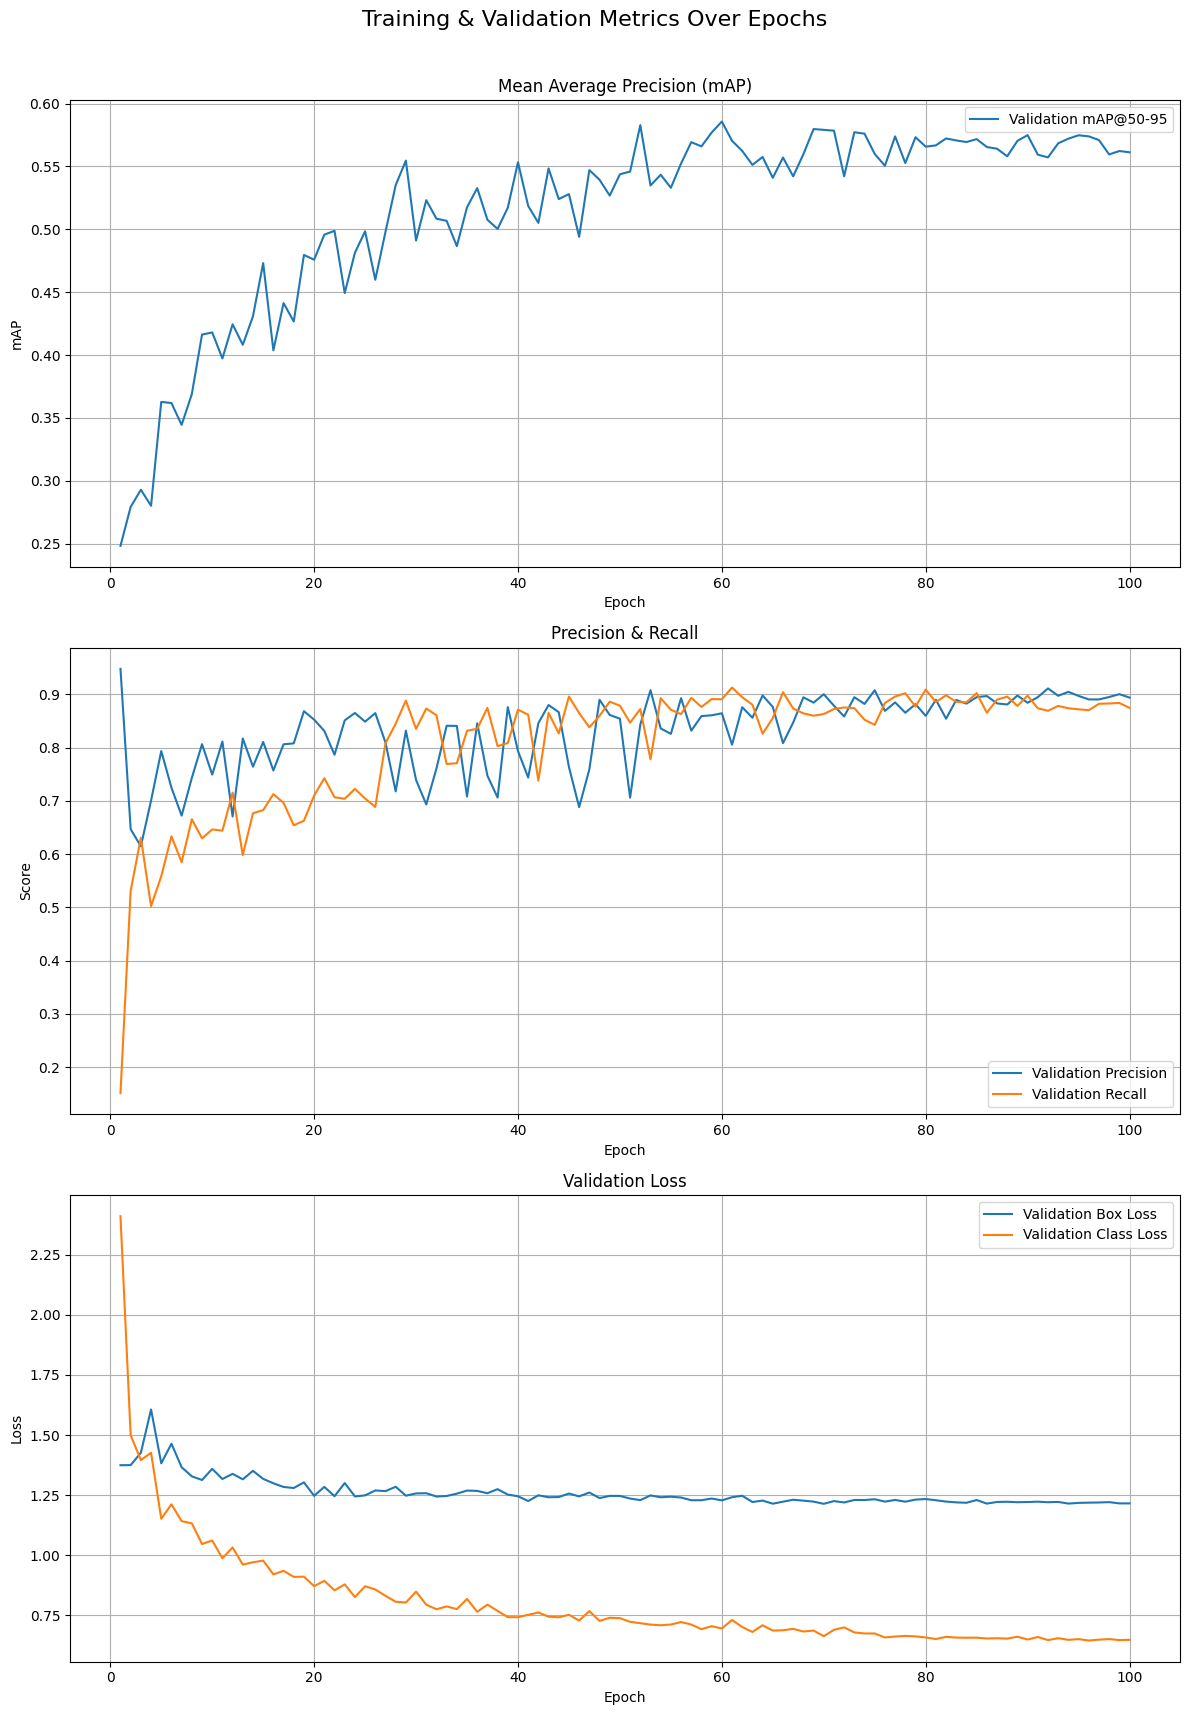

🔍 Displaying confusion matrix...


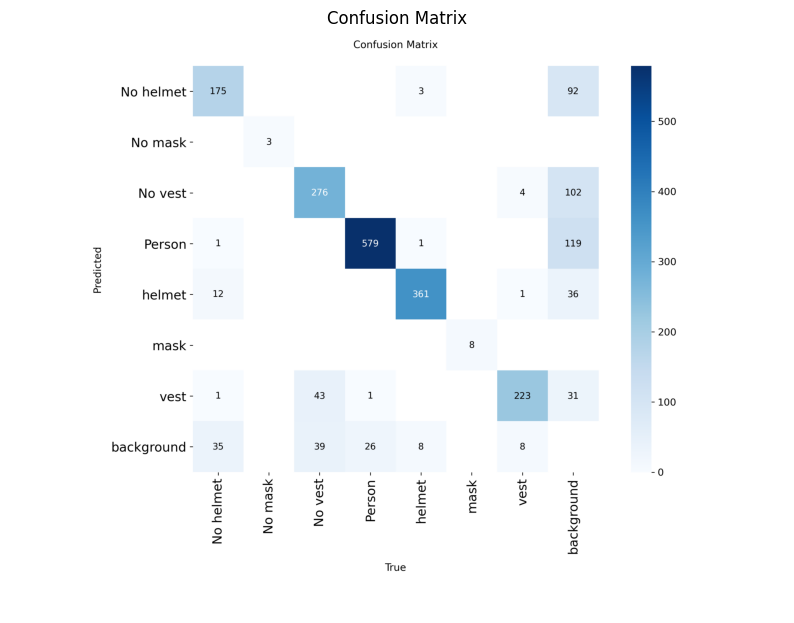

🖼️ Displaying sample validation predictions...


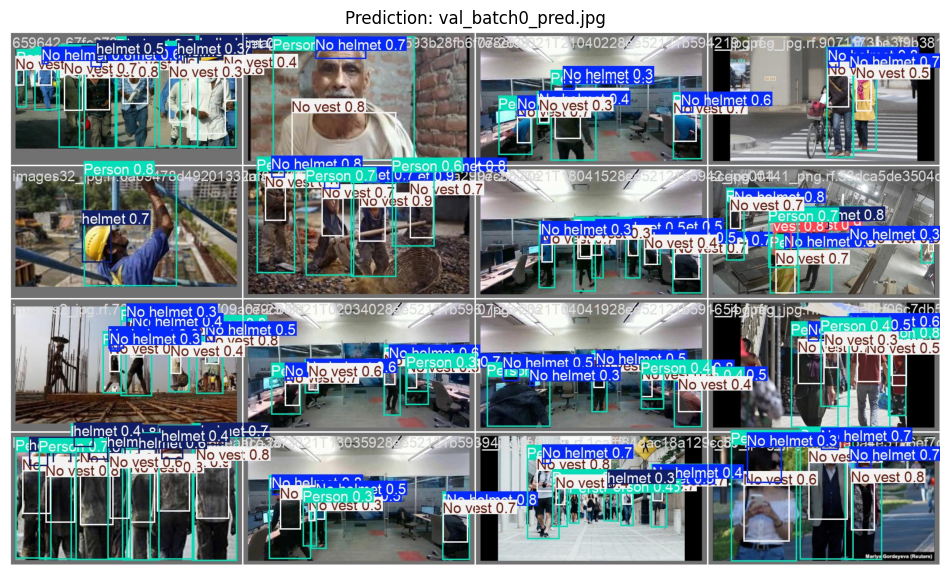

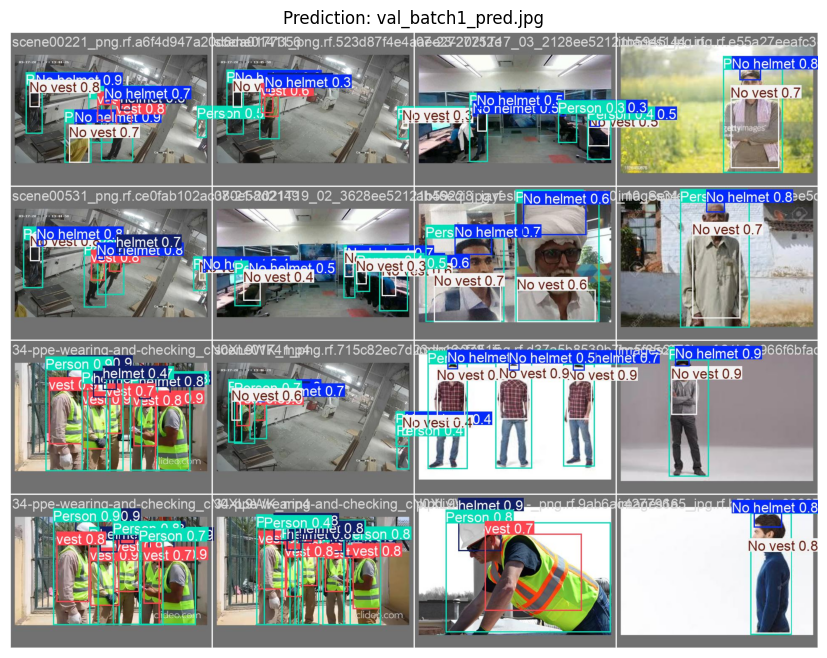

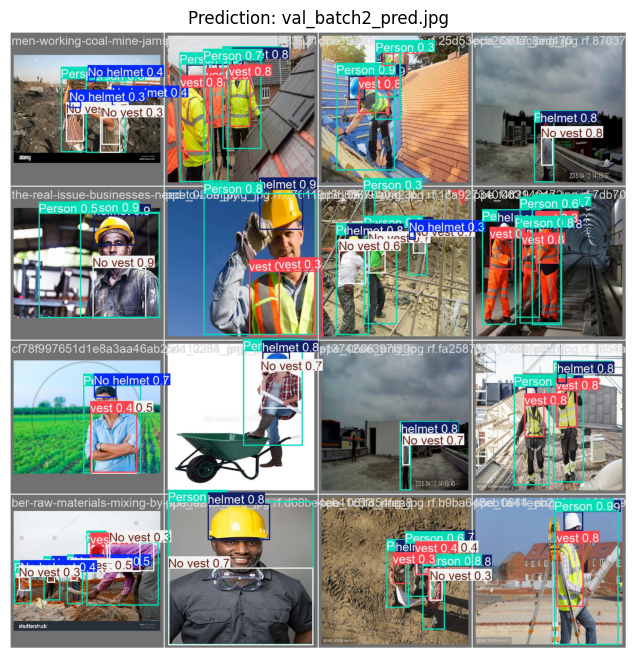

In [3]:
# Import necessary libraries for plotting and image display
import os
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

# --- Configuration ---
# Set the directory where the training results are saved
results_dir = '/content/ppe_detection_project/run3'


# --- Plot Training & Validation Metrics ---
# Path to the results CSV file generated during training
results_path = os.path.join(results_dir, 'results.csv')

# Check if the results file exists
if os.path.exists(results_path):
    print("📈 Plotting training metrics...")
    # Read the results CSV file into a pandas DataFrame
    results_df = pd.read_csv(results_path)
    # Strip any whitespace from the column names
    results_df.columns = results_df.columns.str.strip()
    # Create a figure with 3 subplots
    fig, axes = plt.subplots(3, 1, figsize=(12, 18))
    fig.suptitle('Training & Validation Metrics Over Epochs', fontsize=16)

    # Plot the mean Average Precision (mAP) over epochs
    axes[0].plot(results_df['epoch'], results_df['metrics/mAP50-95(B)'], label='Validation mAP@50-95')
    axes[0].set_title('Mean Average Precision (mAP)')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('mAP')
    axes[0].legend()
    axes[0].grid(True)

    # Plot Precision and Recall over epochs
    axes[1].plot(results_df['epoch'], results_df['metrics/precision(B)'], label='Validation Precision')
    axes[1].plot(results_df['epoch'], results_df['metrics/recall(B)'], label='Validation Recall')
    axes[1].set_title('Precision & Recall')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Score')
    axes[1].legend()
    axes[1].grid(True)

    # Plot the validation loss functions over epochs
    axes[2].plot(results_df['epoch'], results_df['val/box_loss'], label='Validation Box Loss')
    axes[2].plot(results_df['epoch'], results_df['val/cls_loss'], label='Validation Class Loss')
    axes[2].set_title('Validation Loss')
    axes[2].set_xlabel('Epoch')
    axes[2].set_ylabel('Loss')
    axes[2].legend()
    axes[2].grid(True)

    # Adjust the layout of the plots and display them
    plt.tight_layout(rect=[0, 0.03, 1, 0.97])
    plt.show()

else:
    print(f"⚠️ Warning: Could not find 'results.csv' in {results_dir}")


# --- Display the Confusion Matrix ---
# Path to the confusion matrix image generated during training
confusion_matrix_path = os.path.join(results_dir, 'confusion_matrix.png')

# Check if the confusion matrix image exists
if os.path.exists(confusion_matrix_path):
    print("🔍 Displaying confusion matrix...")

    # Open and display the confusion matrix image
    confusion_img = Image.open(confusion_matrix_path)
    plt.figure(figsize=(10, 8))
    plt.imshow(confusion_img)
    plt.title('Confusion Matrix')
    plt.axis('off')
    plt.show()

else:
    print(f"⚠️ Warning: Could not find 'confusion_matrix.png' in {results_dir}")


# --- Display Sample Validation Predictions ---
print("🖼️ Displaying sample validation predictions...")

# Get a list of all validation prediction images from the results directory
val_images = [f for f in os.listdir(results_dir) if f.startswith('val_batch') and f.endswith('_pred.jpg')]

# Display each prediction image
if val_images:
    for img_file in val_images:
        img_path = os.path.join(results_dir, img_file)
        pred_img = Image.open(img_path)

        plt.figure(figsize=(12, 8))
        plt.imshow(pred_img)
        plt.title(f'Prediction: {img_file}')
        plt.axis('off')
        plt.show()
else:
    print(f"⚠️ Warning: No validation prediction images found in {results_dir}")